## Task 3

Utilizziamo il dataset di feature annotato

In [9]:
import os
import pandas as pd

path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "train_data_aggregated.pkl")

df_train_task3_aggregated = pd.read_pickle(file_path)

df_train_task3_aggregated

,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,...,P7_time_variance,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case
0,1,Normal,100,100,100,100,No,No,No,No,...,0.329054,2366.012724,-0.003006,5.017115,47260.680479,64.945878,237314.084554,2632.685347,19.887772,1
1,1,Normal,100,100,100,100,No,No,No,No,...,0.335404,2366.376508,-0.003786,4.999330,47662.864823,64.945878,241893.822061,2688.225229,20.078754,2
2,1,Normal,100,100,100,100,No,No,No,No,...,0.353392,2368.725329,-0.007141,5.000936,46019.998152,64.945878,254866.442384,2743.060363,20.610129,3
3,1,Normal,100,100,100,100,No,No,No,No,...,0.321221,2365.701657,-0.002395,5.008294,46367.986582,64.945878,231664.969366,2565.994380,19.649638,4
4,1,Normal,100,100,100,100,No,No,No,No,...,0.324006,2366.740718,-0.002607,4.998044,46805.662115,64.945878,233673.009183,2592.227655,19.734615,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,3,Anomaly,100,100,100,100,No,No,No,Yes,...,0.307552,2361.961235,0.000442,4.918386,35087.812714,59.950042,221806.924274,2048.184913,19.227018,173
173,3,Anomaly,100,100,100,100,No,No,No,No,...,0.387815,2363.165121,-0.015324,5.228732,28697.613718,62.447960,279692.093116,2114.129783,21.590588,174
174,3,Anomaly,100,100,100,100,No,No,No,No,...,0.346742,2364.069197,0.001778,5.513235,34926.326106,59.950042,250070.258482,1959.034040,20.415283,175
175,3,Anomaly,100,100,100,100,No,No,No,No,...,0.347191,2371.499487,0.266158,4.747359,50273.765483,59.950042,250394.249590,2615.638149,20.428503,176


Filtriamo il dataframe per casi di Condition Anomaly (errori per Bubble Contamination)

In [10]:
# Filtrare solo le righe in cui Condition è 'Anomaly'
df_train_task3_aggregated = df_train_task3_aggregated[df_train_task3_aggregated['Condition'] == 'Anomaly'].copy()

# Dizionario per mappare i sensori sulle classi numeriche
column_to_number = {'BP1': 1, 'BP2': 2, 'BP3': 3, 'BP4': 4, 'BP5': 5, 'BP6': 6, 'BP7': 7, 'BV1': 8}

# Creazione della colonna target con valore predefinito 0 (nessuna anomalia)
df_train_task3_aggregated['anomaly_location'] = 0

# Popolamento della colonna target
for index, row in df_train_task3_aggregated.iterrows():
    for col in column_to_number.keys():
        if row[col] == 'Yes':  # Se il sensore rileva un'anomalia
            df_train_task3_aggregated.at[index, 'anomaly_location'] = column_to_number[col]
            break  # Assegna la prima anomalia trovata e interrompi il ciclo

# Salvataggio del dataset filtrato con target aggiornato
df_train_task3_aggregated.to_csv(os.path.join(path_dataframes, "dataset_train_task3_with_target.csv"), index=False)

# Mostrare alcune righe per conferma
df_train_task3_aggregated[['Condition', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1', 'anomaly_location']]

,Condition,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,anomaly_location
153,Anomaly,Yes,No,No,No,No,No,No,No,1
154,Anomaly,No,Yes,No,No,No,No,No,No,2
155,Anomaly,No,No,Yes,No,No,No,No,No,3
156,Anomaly,No,No,No,Yes,No,No,No,No,4
157,Anomaly,No,No,No,No,Yes,No,No,No,5
158,Anomaly,No,No,No,No,No,Yes,No,No,6
159,Anomaly,No,No,No,No,No,No,Yes,No,7
160,Anomaly,No,No,No,No,No,No,No,Yes,8
161,Anomaly,Yes,No,No,No,No,No,No,No,1
162,Anomaly,No,Yes,No,No,No,No,No,No,2


Features seelction con ANOVA

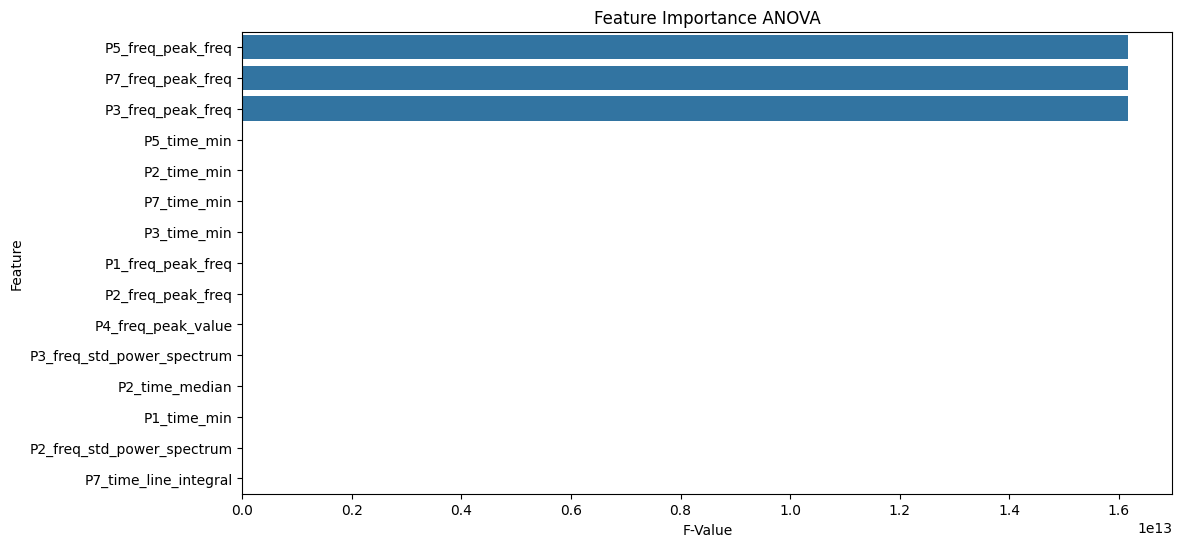

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif

# Separazione delle feature dal target
X = df_train_task3_aggregated.drop(columns=['Spacecraft','BP1','BP2','BP3','BP4','BP5','BP6', 'BP7', 'BV1','SV1','SV2','SV3','SV4','anomaly_location', 'Condition'])  # Escludi il target e la colonna Condition
y = df_train_task3_aggregated['anomaly_location']

# Calcolo del valore F di ANOVA
f_values, p_values = f_classif(X, y)

# Creazione di un DataFrame con i risultati
anova_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
anova_results = anova_results.sort_values(by='F-Value', ascending=False)

# Visualizzazione delle feature più importanti
plt.figure(figsize=(12, 6))
sns.barplot(x='F-Value', y='Feature', data=anova_results[:15])
plt.title('Feature Importance ANOVA')
plt.show()


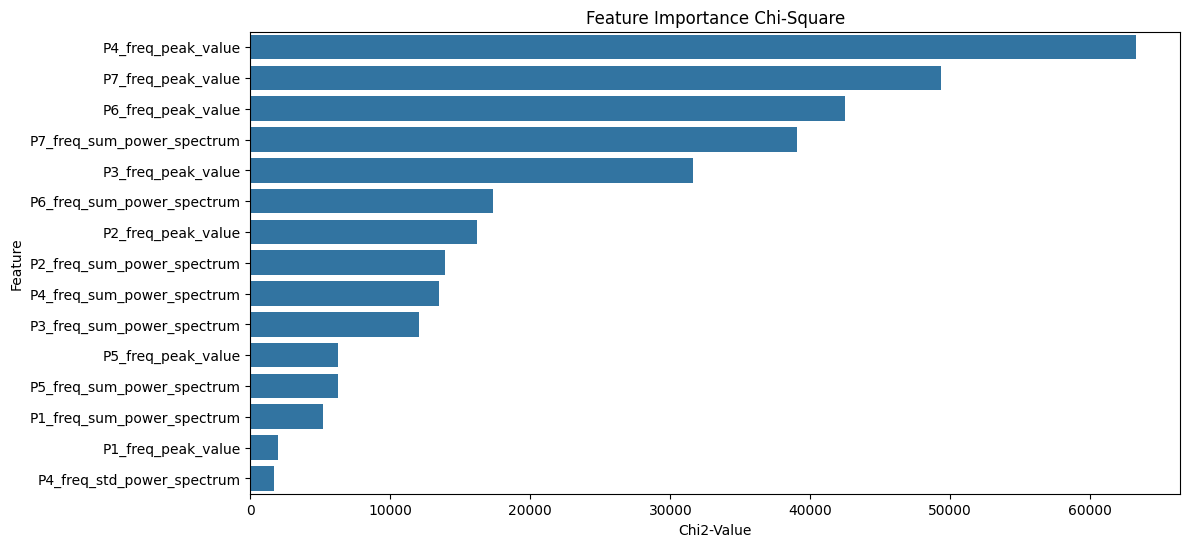

In [14]:
from sklearn.feature_selection import chi2
import numpy as np

# Normalizzazione delle feature per Chi2 (richiede solo valori positivi)
X_chi2 = X - np.min(X) + 1  # Shift per evitare valori negativi
y_chi2 = y

# Calcolo del valore Chi2
chi2_values, chi2_p_values = chi2(X_chi2, y_chi2)

# Creazione di un DataFrame con i risultati
chi2_results = pd.DataFrame({'Feature': X.columns, 'Chi2-Value': chi2_values, 'P-Value': chi2_p_values})
chi2_results = chi2_results.sort_values(by='Chi2-Value', ascending=False)

# Visualizzazione delle feature più importanti
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2-Value', y='Feature', data=chi2_results[:15])
plt.title('Feature Importance Chi-Square')
plt.show()


In [16]:
# Unire le feature più importanti di ANOVA e Chi2
top_features_anova = anova_results[:15]['Feature'].tolist()
top_features_chi2 = chi2_results[:15]['Feature'].tolist()

# Creare una lista unica delle feature selezionate
selected_features = list(set(top_features_anova + top_features_chi2))

# Creare il dataset con le feature selezionate
df_selected = df_train_task3_aggregated[selected_features + ['anomaly_location']]
df_selected

,P2_time_min,P7_time_line_integral,P1_freq_peak_value,P1_time_min,P7_time_min,P4_freq_peak_value,P2_freq_peak_value,P4_freq_sum_power_spectrum,P5_freq_peak_value,P3_freq_std_power_spectrum,...,P3_freq_sum_power_spectrum,P6_freq_sum_power_spectrum,P2_time_median,P2_freq_sum_power_spectrum,P7_freq_peak_value,P3_freq_peak_freq,P4_freq_std_power_spectrum,P1_freq_peak_freq,P5_time_min,anomaly_location
153,0.274147,2361.286896,10802.636968,0.598692,0.000599,31959.671511,23956.453644,198781.726242,28393.350414,1784.354772,...,177254.112328,222070.082557,1.930621,137404.314915,39642.577062,64.945878,1947.447557,64.945878,0.000563,1
154,0.562916,2366.205104,10735.216150,0.561754,-0.003637,34667.506912,29519.582443,238159.901617,27500.006767,1878.188463,...,190319.433203,213988.909509,1.919967,147631.914817,34566.752154,62.447960,2162.956545,62.447960,0.020600,2
155,0.103320,2366.238784,7917.770581,0.409866,-0.004556,31317.015317,22405.240961,260115.579000,20975.587187,2118.547498,...,216163.432394,203522.737506,1.923975,140512.179038,26007.540065,59.950042,2149.346127,59.950042,0.019675,3
156,0.053372,2361.818259,9475.374287,0.543228,0.011591,47903.191043,27973.038166,242451.446171,24603.112894,1831.385585,...,202618.665026,200821.230453,1.918731,144303.979111,32312.378412,59.950042,2587.991587,59.950042,-0.001572,4
157,0.021869,2358.758370,9489.428532,0.767459,-0.005569,24055.889699,20748.702617,197384.051931,30290.462272,1525.789206,...,171223.678247,218225.318468,1.946931,128013.954373,36055.313277,62.447960,1677.093411,62.447960,0.482296,5
158,0.024311,2363.743831,10420.485801,0.525390,-0.001953,25033.935950,22468.254175,192121.549995,35113.671262,1425.537134,...,165834.955152,265713.552707,1.943923,123137.615311,46647.583532,59.950042,1547.362531,59.950042,0.287499,6
159,0.016551,2371.162469,9708.256727,0.581337,0.349276,22356.103914,21111.691154,192557.994856,33264.591568,1368.976618,...,165408.303332,252479.826682,1.949996,123975.728475,65966.475641,59.950042,1490.331780,59.950042,0.202666,7
160,0.246233,2360.344570,10766.257716,0.655410,-0.001480,32274.528351,24425.133285,200215.512432,28189.829236,1755.320903,...,178969.741862,219198.052093,1.927557,140164.983855,38827.182194,64.945878,1948.205401,64.945878,0.000563,8
161,0.268553,2359.249664,11074.908154,0.716829,-0.003207,32105.578256,24088.431939,249457.937097,28231.548278,1845.964331,...,224049.118735,213159.402792,1.926315,140448.081123,39760.234739,64.945878,1971.148694,64.945878,0.000563,1
162,0.561062,2365.532333,10907.343218,0.563947,-0.003646,34536.942712,30187.095143,257493.895496,27623.310916,1980.313013,...,209152.048226,206552.340285,1.916744,153392.598010,34649.756869,62.447960,2156.372065,62.447960,0.017047,2


PROBLEMA: pochi casi di Train per le Bubble Contmination, proviamo ad aumentare i campioni

Controllo la distribuzione delle classi prima

C:\Users\kikop\AppData\Local\Temp\ipykernel_3616\3434480410.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_selected['anomaly_location'], palette="viridis")


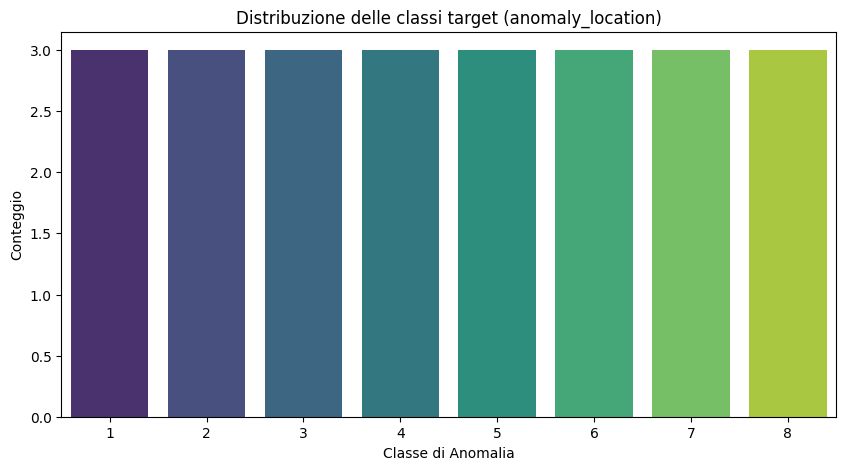

In [20]:
# Controllo distribuzione delle classi target
plt.figure(figsize=(10, 5))
sns.countplot(x=df_selected['anomaly_location'], palette="viridis")
plt.title("Distribuzione delle classi target (anomaly_location)")
plt.xlabel("Classe di Anomalia")
plt.ylabel("Conteggio")
plt.show()

C:\Users\kikop\AppData\Local\Temp\ipykernel_3616\3358892311.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_augmented['anomaly_location'], palette="viridis")


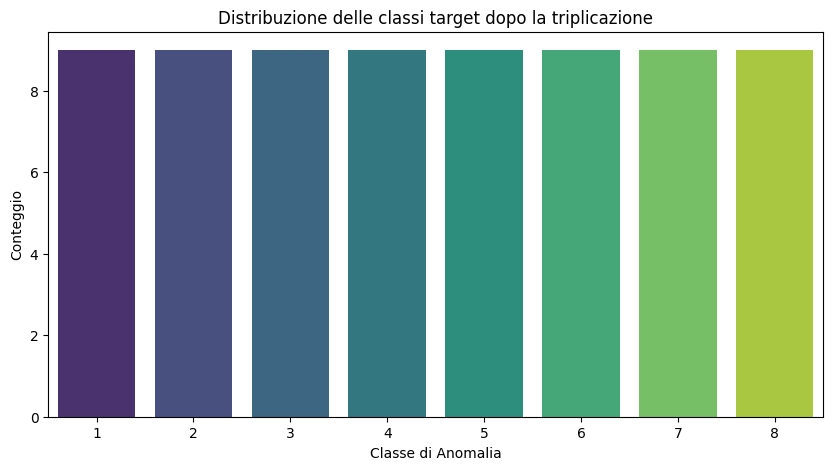

In [23]:
import pandas as pd

# Triplicazione dei dati
df_augmented = pd.concat([df_selected] * 3, axis=0).reset_index(drop=True)

# Salvataggio del dataset aumentato
df_augmented.to_csv(os.path.join(path_dataframes, "dataset_train_task3_triplicated.csv"), index=False)

# Controllo distribuzione dopo l'aumento
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(x=df_augmented['anomaly_location'], palette="viridis")
plt.title("Distribuzione delle classi target dopo la triplicazione")
plt.xlabel("Classe di Anomalia")
plt.ylabel("Conteggio")
plt.show()


In [26]:
df_augmented

,P2_time_min,P7_time_line_integral,P1_freq_peak_value,P1_time_min,P7_time_min,P4_freq_peak_value,P2_freq_peak_value,P4_freq_sum_power_spectrum,P5_freq_peak_value,P3_freq_std_power_spectrum,...,P3_freq_sum_power_spectrum,P6_freq_sum_power_spectrum,P2_time_median,P2_freq_sum_power_spectrum,P7_freq_peak_value,P3_freq_peak_freq,P4_freq_std_power_spectrum,P1_freq_peak_freq,P5_time_min,anomaly_location
0,0.274147,2361.286896,10802.636968,0.598692,0.000599,31959.671511,23956.453644,198781.726242,28393.350414,1784.354772,...,177254.112328,222070.082557,1.930621,137404.314915,39642.577062,64.945878,1947.447557,64.945878,0.000563,1
1,0.562916,2366.205104,10735.216150,0.561754,-0.003637,34667.506912,29519.582443,238159.901617,27500.006767,1878.188463,...,190319.433203,213988.909509,1.919967,147631.914817,34566.752154,62.447960,2162.956545,62.447960,0.020600,2
2,0.103320,2366.238784,7917.770581,0.409866,-0.004556,31317.015317,22405.240961,260115.579000,20975.587187,2118.547498,...,216163.432394,203522.737506,1.923975,140512.179038,26007.540065,59.950042,2149.346127,59.950042,0.019675,3
3,0.053372,2361.818259,9475.374287,0.543228,0.011591,47903.191043,27973.038166,242451.446171,24603.112894,1831.385585,...,202618.665026,200821.230453,1.918731,144303.979111,32312.378412,59.950042,2587.991587,59.950042,-0.001572,4
4,0.021869,2358.758370,9489.428532,0.767459,-0.005569,24055.889699,20748.702617,197384.051931,30290.462272,1525.789206,...,171223.678247,218225.318468,1.946931,128013.954373,36055.313277,62.447960,1677.093411,62.447960,0.482296,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.055974,2361.961235,10790.870749,0.543228,0.000442,55525.069026,32288.676208,263153.420841,27739.109293,2145.386664,...,237160.315947,299152.848218,1.917474,159769.197452,35087.812714,59.950042,2958.653524,59.950042,-0.000242,4
68,0.026173,2363.165121,8209.481967,0.820108,-0.015324,21443.938547,18078.752523,258182.863795,26099.264386,1537.075918,...,207703.520314,253710.248339,1.947003,137381.466475,28697.613718,62.447960,1739.551355,62.447960,0.428513,5
69,0.017439,2364.069197,8830.192756,0.522027,0.001778,23844.279298,19342.494188,264046.781598,29476.479202,1359.671689,...,204831.471450,261513.624476,1.944042,132866.829775,34926.326106,59.950042,1680.416668,59.950042,0.287499,6
70,0.016213,2371.499487,7229.156634,0.579673,0.266158,16125.687822,15837.670271,249850.781174,24806.441373,1243.535779,...,199358.441712,263038.077024,1.949303,132447.814818,50273.765483,59.950042,1424.403025,59.950042,0.213047,7


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separazione feature e target
X = df_augmented.drop(columns=['anomaly_location'])
y = df_augmented['anomaly_location']

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizzazione delle feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Creazione e addestramento del modello
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predizione sul test set
y_pred = clf.predict(X_test_scaled)

# Report delle prestazioni
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[3 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 3]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

